https://datascienceplus.com/time-series-analysis-with-wind-resource-assessment-in-r/

https://github.com/mhdella/AWEA_WRA_Working_Group/blob/master/Example_Wind_Resource_Assessment_Using_R.md

# Example Wind Resource Assessment Using Python
Cory Jog 2018-06-06,

A Python tranlation of Stephen Lightfoote's [original post in R](https://github.com/srlightfoote/AWEA_WRA_Working_Group/blob/master/Example_Wind_Resource_Assessment_Using_R.md#packages). 

## Example Wind Resource Assessment
The goal here is to illustrate how aspects of typical wind resource assessment and energy capture from meteorological data can be accomplished using open source tools, in this case using Python. Using publicly available data, we'll walk through some of the typical steps taken in site screening, importing, visualizing and analyzing meteorological data with the goal of modeling the annual energy capture of a wind turbine at a given location. For kicks, as a wink to the NIMBY's out there, let's use Stephen's backyard as the example.

### Packages
First, load the R packages used to do the analysis.

In [3]:
# import anemoi as an
import pandas as pd
import numpy as np
import scipy as sp

import scipy.optimize as spyopt
from scipy.special import gamma

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import seaborn as sns
sns.set_context('talk')

import io
import requests

## Get Wind Data

Next, we'll download some sample wind resource data from NREL's wind toolkit to see how energetic my location is. The variable arguments in the paste statement below should be replaced with your own information (see https://developer.nrel.gov/signup/ to get an API key).

In [21]:
api_key='zZN9lLYGEIuYd6ruQynCnwBYBAg0bwkkutTBLMfh'
api_key

'zZN9lLYGEIuYd6ruQynCnwBYBAg0bwkkutTBLMfh'

In [20]:
###Wind Farm 10 miles northwest Boston  
# lat=42.2756887
# lon=-71.21161789999996 

###Boulder  
lat=40.0150
lon=-105.2705

In [24]:
api_inputs = dict(api_key=api_key,
                 lat=lat,
                 lon=lon,
                 name='Mohamed Abuella',
                 affiliation='UNCC',
                 email='mhdabuella@gmail.com')

url = "http://developer.nrel.gov/api/wind-toolkit/wind/wtk_download.csv?api_key={api_key}&wkt=POINT({lon}%20{lat})&attributes=wind_speed,wind_direction,power,temperature,pressure&names=2009&full_name={name}&email={email}&affiliation={affiliation}&reason=Example,sep=','".format(**api_inputs)
result = requests.get(url).content
data = pd.read_csv(io.StringIO(result.decode('utf-8')), header=3)
data.index = pd.to_datetime(data.loc[:,['Year','Month','Day','Hour','Minute']])
data = data.drop(['Year','Month','Day','Hour','Minute'], axis=1)

ws_col = 'wind speed at 100m (m/s)'
dir_col = 'wind direction at 100m (deg)'

## Exploratory Analysis
Now to the meat of the post, which is to illustrate how to analyze and visualize typical steps for wind resource assessment.

### Data Structure

In [25]:
data.head()

,wind speed at 100m (m/s),wind direction at 100m (deg),power (MW),air temperature at 2m (K),surface air pressure (Pa)
2009-01-01 00:00:00,12.104,289.875,11.674,280.160,80372.352
2009-01-01 00:05:00,9.525,290.604,8.441,279.690,80370.520
2009-01-01 00:10:00,7.353,303.515,4.138,279.018,80374.192
2009-01-01 00:15:00,4.250,321.365,0.536,275.128,80382.432
2009-01-01 00:20:00,2.143,358.319,0.000,274.231,80423.624


### Timeseries

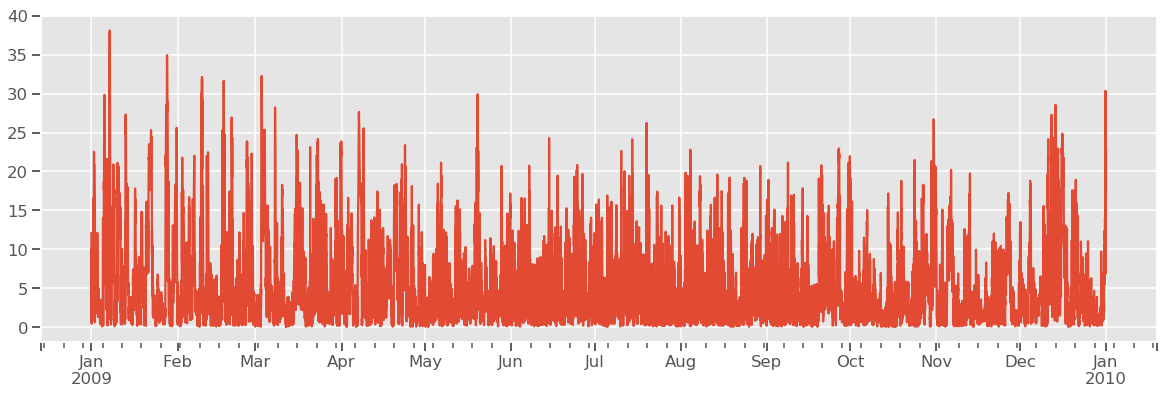

In [26]:
data[ws_col].plot(figsize=[20,6]);

### Monthly Wind Speed Distribution

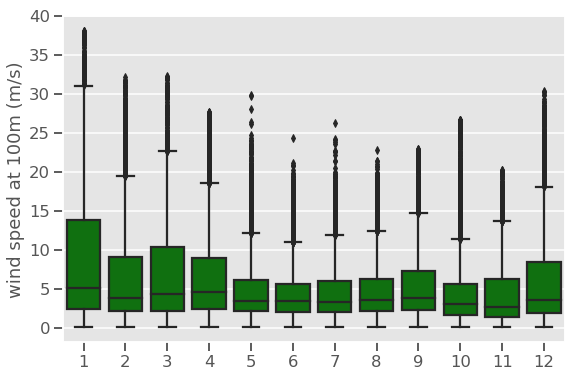

In [27]:
fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111)
sns.boxplot(data=data, x=data.index.month, y=ws_col, color='green', ax=ax)
plt.show()

### Wind Rose

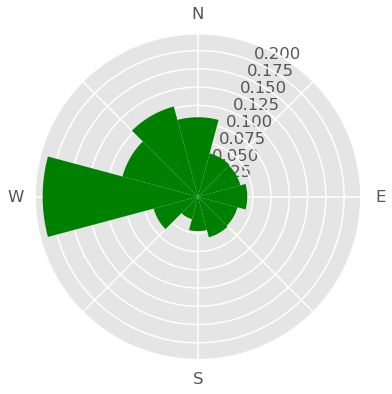

In [28]:
bin_width = 30
dir_bins = np.floor_divide(np.mod(data[dir_col] + (bin_width/2.0),360.0),bin_width)
freq_by_dir = dir_bins.groupby(dir_bins).count() / dir_bins.shape[0]

fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction('clockwise')
ax.set_theta_zero_location('N')
ax.bar(np.radians(freq_by_dir.index.values*bin_width), freq_by_dir, width=np.radians(360.0/freq_by_dir.shape[0]), color='green')
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
plt.show()

### Weibull Fit

In [31]:
def euro_atlas_fit(ws_data):
    '''European Wind Atlas approach for calculating weibull parameters.
    This approach specifies the following contraints:
    - The total wind energy in the fitted weibull distribution must be equal
    to that of the observed distribution
    -The frequency of occurence of the wind speeds higher than the observed
    average speeds are the same for the two distributions, effectively placing
    more emphasis on the energetic wind speeds
    '''

    def estimate_weibull_k(ws_data, ws_mean, third_order_moment, prob_exceed_mean):
        k = np.exp(-(ws_mean/(third_order_moment/gamma(1.0+3.0/ws_data))**(1.0/3.0))**ws_data)-prob_exceed_mean
        return k

    third_order_moment = np.sum(ws_data**3.0)/len(ws_data)
    exceed_mean = ws_data > np.mean(ws_data)
    prob_exceed_mean = np.sum(exceed_mean, dtype=float)/len(ws_data)

    solve_k = spyopt.fsolve(estimate_weibull_k, x0=[2], args=(np.mean(ws_data), third_order_moment, prob_exceed_mean))
    k = np.round(solve_k[0], 3)
    A = np.round((third_order_moment/gamma(1+(3.0/k)))**(1.0/3.0), 3)
    return A, k

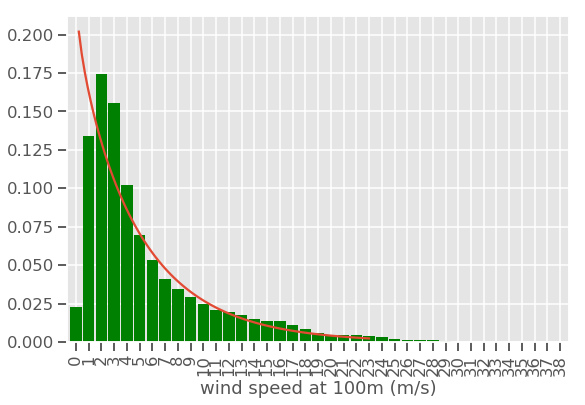

In [32]:
A,k = euro_atlas_fit(data[ws_col].values)
freq_by_ws = data[ws_col].groupby(data[ws_col].round()).count() / data.shape[0]
freq_by_ws.index = freq_by_ws.index.astype(int)

x = np.linspace(0,23,100)

fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111)
freq_by_ws.plot(kind='bar', color='green', width=0.9, ax=ax)
ax.plot(x, sp.stats.exponweib(1, k, scale=A, loc=0).pdf(x))
plt.show()